In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import pytz
import sklearn
import scipy

In [35]:
#check versions of packages
import sys
print(sys.version)
print('pandas version:', pd.__version__)
print('numpy version:', np.__version__)
print('seaborn:', sns.__version__)
print('re version:', re.__version__)
print('pytz version:', pytz.__version__)
print('sklearn version:', sklearn.__version__)
print('scipy version:', scipy.__version__)

3.11.8 | packaged by Anaconda, Inc. | (main, Feb 26 2024, 21:34:05) [MSC v.1916 64 bit (AMD64)]
pandas version: 2.2.1
numpy version: 1.26.4
seaborn: 0.12.2
re version: 2.2.1
pytz version: 2023.3.post1
sklearn version: 1.2.2
scipy version: 1.11.4


In [36]:
data = pd.read_csv('CPS.csv')

In [37]:
# Select and rename relevant columns for analysis out of the 356 original columns 
selected_columns = {
    # Household Information
    'hrhhid2': 'household_id',
    'HUFINAL': 'interview_outcome',
    'hrnumhou': 'household_members',  # Number of members in a household

    # Education and Certification Details
    'peschlvl': 'highest_level_of_school',  # Highest level of school 
    'peeduca': 'education_level',  # Highest level of education completed
    'peedegr': 'highest_degree_earned',  # Highest degree earned
    'petrain': 'received_job_training',  # Received job training past high school
    'pecert1': 'professional_certification1',  # Professional certification 1
    'pecert2': 'cert_issued_by_state_or_gov',  # Is certificate issued by the state or the federal government?
    'pecert3': 'is_cert_required',  # Is certification needed for the job?

    # Employment and Income Details
    'pemlr': 'employment_status',  # Employment status
    'prunedor': 'duration_of_unemployment',  # Duration of unemployment
    'hefaminc': 'family_income',  # Family income
    'primind1': 'primary_industry_code_job1',  # Primary industry code for job 1
    'peio1icd': 'industry_code_job1',  # Industry code for job 1
    'ptio1ocd': 'occupation_code_job1',  # Occupation code for job 1
    'primind2': 'primary_industry_code_job2',  # Primary industry code for job 2
    'peio2icd': 'industry_code_job2',  # Industry code for job 2
    'ptio2ocd': 'occupation_code_job2',  # Occupation code for job 2
    'puwk': 'did_work_last_week',  # Did the individual work last week
    
    # Earnings
    'peernhry': 'hourly_earnings',  # Hourly earnings
    'pternh1c': 'earnings_first_job',  # Earnings from the first job
    'pthr': 'total_hours_worked',  # Total hours worked
    'pternwa': 'weekly_earnings',  # Weekly earnings

    # Demographic Variables
    'ptdtrace': 'race',  # Race
    'pesex': 'gender',  # Gender
    'prcitshp': 'citizenship_status',  # Citizenship status

     # Geographic Information
    'gestfips': 'state_code',  # State FIPS code
    

     # Work Arrangement and Preferences
    'pehruslt': 'usual_hours_worked',  # Usual hours worked per week
    'pewa': 'work_at_home',  # Ability or frequency of working from home
    'pewm': 'work_multiple_jobs',  # Working multiple jobs
    
   
     # Job Search and Unemployment Details
    'pruntype': 'reason_for_unemployment',  # Reason for unemployment
    'pulaydtx': 'weeks_looking_for_work',  # Weeks spent looking for work
    'pulkm1': 'primary_method_of_job_search',  # Primary method of job search
    'puhrck12': 'job_search_method',  # Job search method

     # Health and Disability
    'pedisabl': 'disability_status',  # Disability status
    'pehspnon': 'health_status_impacting_work',  # Health status impacting work
    
}

In [38]:
# Filter the dataset to keep only the selected columns, verifying they exist
data_filtered = data[[col for col in selected_columns if col in data.columns]].rename(columns=selected_columns)

In [39]:
data_filtered.head(5)

,household_id,interview_outcome,household_members,highest_level_of_school,education_level,professional_certification1,cert_issued_by_state_or_gov,is_cert_required,employment_status,family_income,...,earnings_first_job,total_hours_worked,weekly_earnings,race,gender,citizenship_status,state_code,usual_hours_worked,reason_for_unemployment,health_status_impacting_work
0,15011,201,3,-1.0,37.0,2.0,-1.0,-1.0,4.0,12,...,-1.0,0,-1.0,1.0,2.0,1.0,1,-1.0,2.0,2.0
1,15011,201,3,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,12,...,-1.0,0,-1.0,1.0,1.0,1.0,1,-1.0,-1.0,2.0
2,15011,201,3,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,12,...,-1.0,0,-1.0,1.0,2.0,1.0,1,-1.0,-1.0,2.0
3,16011,201,1,-1.0,40.0,2.0,-1.0,-1.0,1.0,13,...,-1.0,0,115400.0,1.0,2.0,1.0,1,40.0,-1.0,2.0
4,15011,201,2,-1.0,40.0,2.0,-1.0,-1.0,1.0,16,...,-1.0,0,72000.0,1.0,1.0,1.0,1,40.0,-1.0,2.0


In [71]:
# Replace -1 with NaN in specific columns where -1 signifies missing data
columns_to_replace = ['highest_level_of_school', 'education_level', 'professional_certification1',
                      'cert_issued_by_state_or_gov', 'is_cert_required', 'employment_status',
                      'usual_hours_worked', 'reason_for_unemployment', 'health_status_impacting_work']
for column in columns_to_replace:
    data_filtered[column] = data_filtered[column].replace(-1, np.nan)


In [67]:
# Ensure categorical data is correctly typed
categorical_columns = ['employment_status', 'professional_certification1', 'race', 'gender', 'citizenship_status', 'primary_industry_code_job1']
for col in categorical_columns:
    data_filtered[col] = data_filtered[col].astype('category')

In [68]:
data_filtered.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 126784 entries, 0 to 126783
Data columns (total 27 columns):
 #   Column                        Non-Null Count   Dtype   
---  ------                        --------------   -----   
 0   household_id                  126784 non-null  int64   
 1   interview_outcome             126784 non-null  int64   
 2   household_members             126784 non-null  int64   
 3   highest_level_of_school       7134 non-null    float64 
 4   education_level               82667 non-null   float64 
 5   professional_certification1   82348 non-null   category
 6   cert_issued_by_state_or_gov   13803 non-null   float64 
 7   is_cert_required              12012 non-null   float64 
 8   employment_status             82348 non-null   category
 9   family_income                 126784 non-null  int64   
 10  primary_industry_code_job1    99250 non-null   category
 11  industry_code_job1            99250 non-null   float64 
 12  occupation_code_job1          

PEEDUCA			2		HIGHEST LEVEL OF SCHOOL 								137 - 138
					COMPLETED OR DEGREE RECEIVED 

					EDITED UNIVERSE:	PRPERTYP = 2 0R 3				

					VALID ENTRIES

					31	LESS THAN 1ST GRADE
					32	1ST, 2ND, 3RD OR 4TH GRADE
					33	5TH OR 6TH GRADE
					34	7TH OR 8TH GRADE
					35	9TH GRADE
					36	10TH GRADE
					37	11TH GRADE
					38	12TH GRADE NO DIPLOMA
					39	HIGH SCHOOL GRAD-DIPLOMA OR EQUIV (GED)
					40	SOME COLLEGE BUT NO DEGREE
					41	ASSOCIATE DEGREE-OCCUPATIONAL/VOCATIONAL
					42	ASSOCIATE DEGREE-ACADEMIC PROGRAM
					43	BACHELOR'S DEGREE (EX: BA, AB, BS)
					44	MASTER'S DEGREE (EX: MA, MS, MEng, MEd, MSW)
					45	PROFESSIONAL SCHOOL DEG (EX: MD, DDS, DVM)
					46	DOCTORATE DEGREE (EX: PhD, EdD)


C:\Users\almas\anaconda3\envs\DS\Lib\site-packages\seaborn\categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


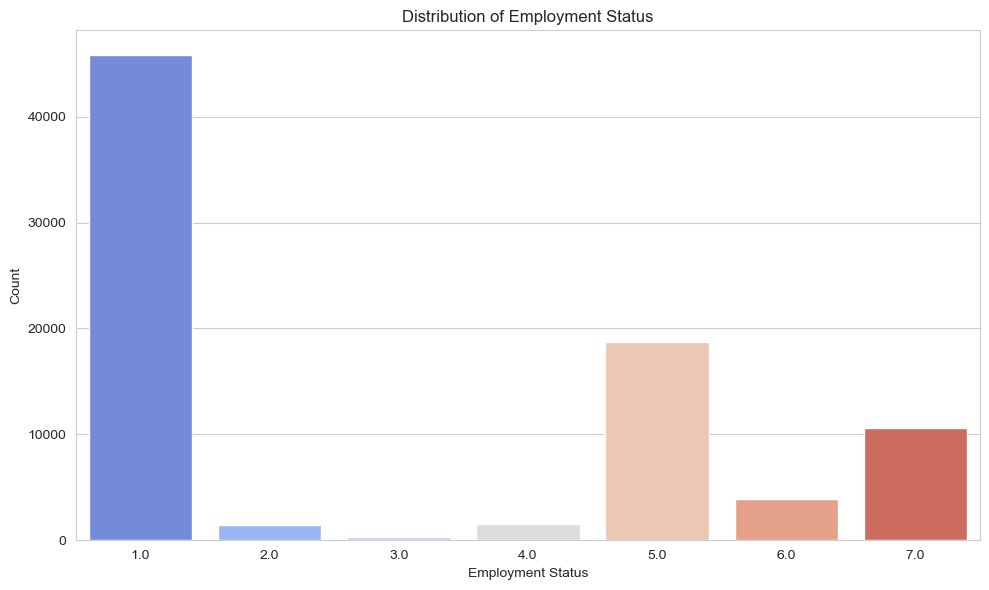

In [57]:

# Set the aesthetic style of the plots
sns.set_style('whitegrid')


## Visualization 1: Employment Status Distribution
plt.figure(figsize=(10, 6))
sns.countplot(x='employment_status', data=data_filtered, palette='coolwarm')
plt.title('Distribution of Employment Status')
plt.xlabel('Employment Status')
plt.ylabel('Count')
plt.tight_layout()
plt.show()


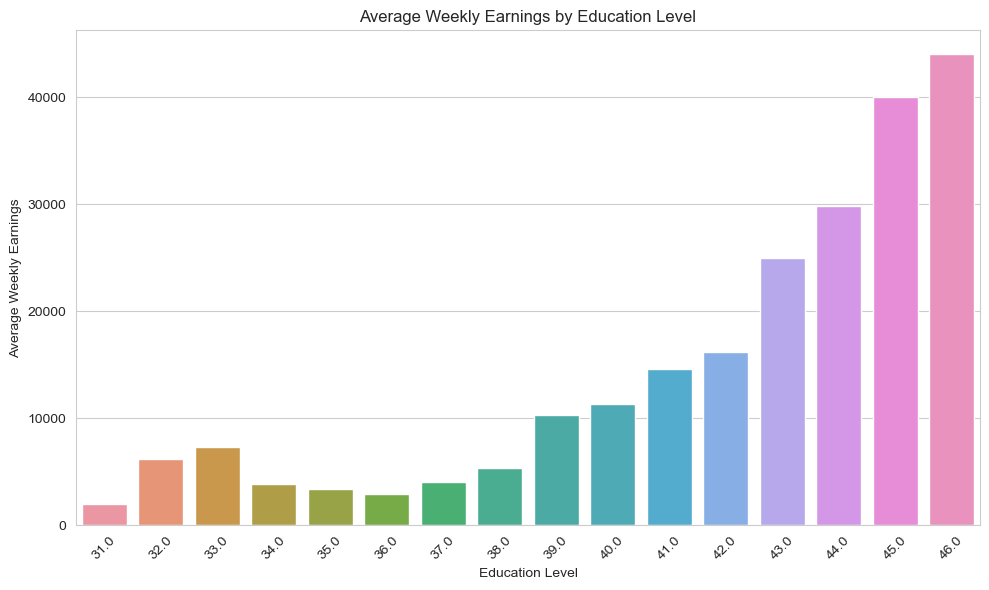

In [51]:
## Visualization 2: Average Weekly Earnings by Education Level
plt.figure(figsize=(10, 6))
sns.barplot(x='education_level', y='weekly_earnings', data=data_filtered, estimator=np.mean, errorbar=None)
plt.title('Average Weekly Earnings by Education Level')
plt.xlabel('Education Level')
plt.ylabel('Average Weekly Earnings')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

C:\Users\almas\anaconda3\envs\DS\Lib\site-packages\seaborn\categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


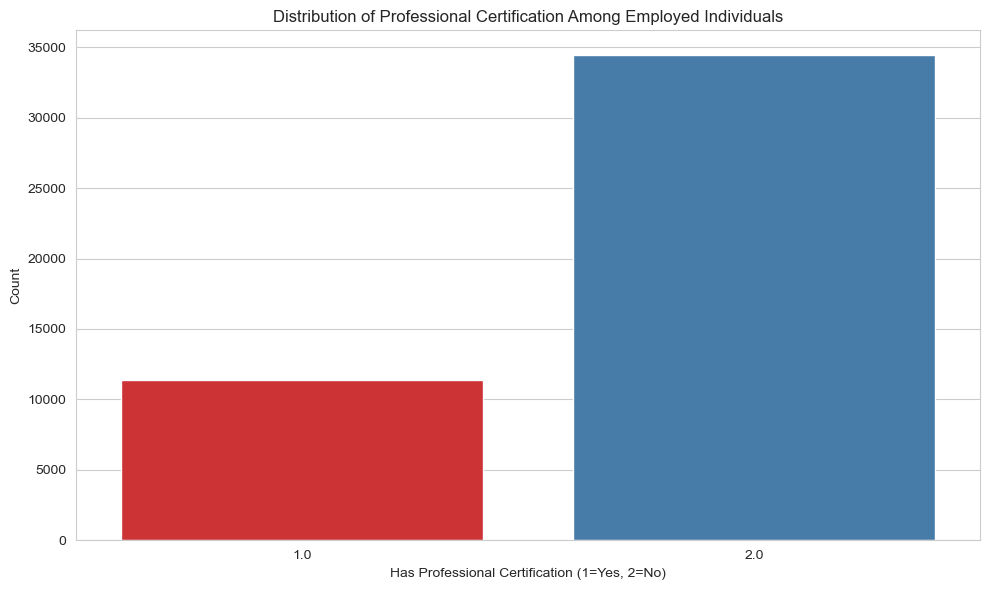

In [61]:
# Filter data for employed individuals
employed_data = data_filtered[data_filtered['employment_status'] == 1.0]  

plt.figure(figsize=(10, 6))
sns.countplot(x='professional_certification1', data=employed_data, palette='Set1')
plt.title('Distribution of Professional Certification Among Employed Individuals')
plt.xlabel('Has Professional Certification (1=Yes, 2=No)')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

C:\Users\almas\anaconda3\envs\DS\Lib\site-packages\seaborn\categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)
C:\Users\almas\anaconda3\envs\DS\Lib\site-packages\seaborn\categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


AttributeError: 'numpy.float64' object has no attribute 'startswith'

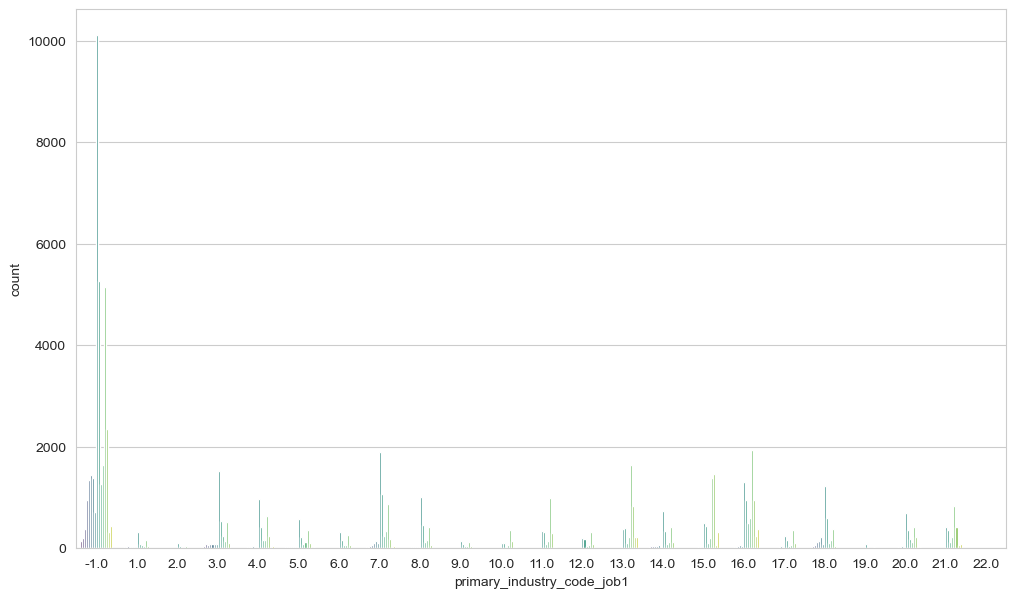

In [69]:
## Visualization 4: Distribution of Job Industries by Education Level
plt.figure(figsize=(12, 7))
sns.countplot(x='primary_industry_code_job1', hue='education_level', data=data_filtered, palette='viridis')
plt.title('Distribution of Job Industries by Education Level')
plt.xlabel('Primary Industry Code Job 1')
plt.ylabel('Count')
plt.xticks(rotation=90)
plt.legend(title='Education Level', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

# Show plots
plt.show()
